## GPyTorch Playground

This is just a notebook to play with GPs, useful for testing things for Bayes Opt prior to implementation

In [1]:
import math
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, MaternKernel
import matplotlib.pyplot as plt

### Very Simple Example Setup

In [2]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [3]:
train_x = torch.linspace(0, 10, 10)
train_y = torch.sin(train_x) + torch.sin(train_x * 2.)

test_x = torch.linspace(0, 10, 1000)

In [4]:
lh = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, lh)

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(lh, model)

for i in range(50):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()


In [6]:
model.eval()
lh.eval()
pred_dist = lh(model(test_x))

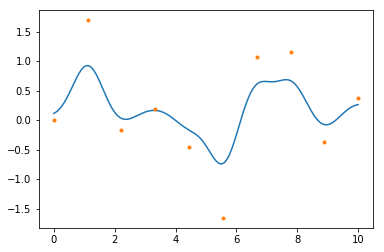

In [7]:
plt.plot(test_x, pred_dist.mean.detach())
plt.plot(train_x, train_y, marker='.', linestyle="None")
plt.show()


### Let's Whip Up this Bayes Opt Thing

In [18]:
import dcc
from dcc.bayesopt import BayesOpt
import numpy as np

In [19]:
def true_func(x):
    ## Just a dumb function that we can try to optimize ##
    return 8 * torch.sin(x * 0.015) - 0.0001 * (x - 500)**2 + 25

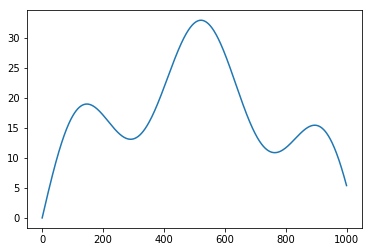

In [20]:
all_x = torch.arange(0, 1000)
all_y = true_func(all_x)

plt.plot(all_x, all_y.detach())
plt.show()

In [21]:
train_x = torch.tensor(np.random.choice(all_x, 5, replace=False))
train_y = true_func(train_x)

#### Build BO model and train

In [22]:
bayes_opt = BayesOpt(train_x, train_y, RBFKernel)
bayes_opt.train_surrogate(iters=500)

#### Test that it actually fit

In [23]:
bayes_opt.surrogate_lh.eval()
bayes_opt.surrogate.eval()

tx = bayes_opt.train_x
ty = bayes_opt.train_y
test_points = torch.arange(0, 1000).float()
scaled_test_points = (test_points - bayes_opt.x_mean).div(bayes_opt.x_std)

pred = bayes_opt.surrogate_lh(bayes_opt.surrogate(scaled_test_points)).mean
truth = (true_func(test_points) - bayes_opt.y_mean).div(bayes_opt.y_std)

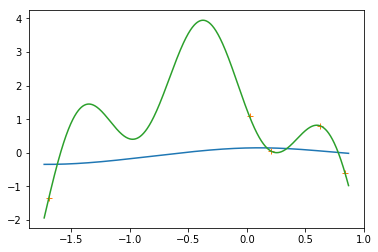

In [24]:
plt.plot(scaled_test_points, pred.detach())
plt.plot(tx, ty, linestyle="None", marker='+')
plt.plot(scaled_test_points, truth)
plt.show()

In [25]:
test, acq = bayes_opt.acquire()

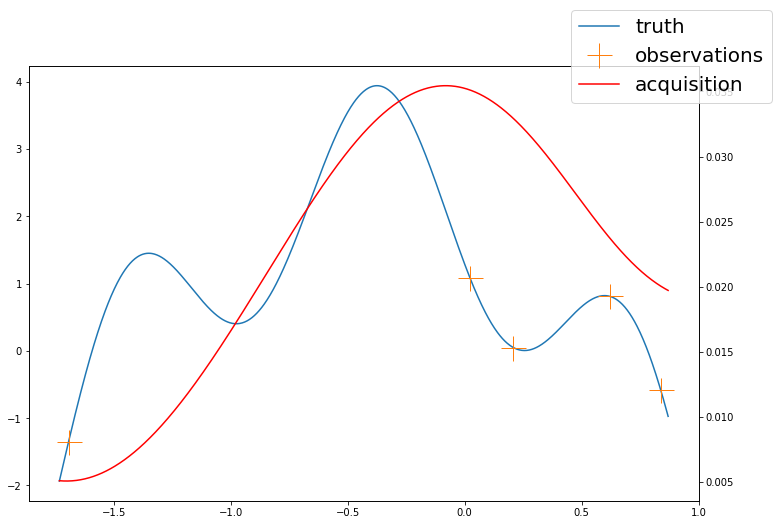

In [33]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(scaled_test_points, truth, label="truth")
ax1.plot(tx, ty, marker='+', linestyle="None", 
         markersize=25, label='observations')

ax2 = ax1.twinx()
ax2.plot(test, acq.detach(), color="red", label="acquisition")
fig.legend(loc='upper right', fontsize=20)
plt.show()